In [1]:
import glob
import os
import librosa
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

/home/tianwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
seed = 1234
tf.set_random_seed(seed)
np.random.seed(seed)

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [4]:
#### Logit to evidence converters - activation functions (they have to produce non-negative outputs for the uncertaintyuncertainity process)

def relu_evidence(logits):
    return tf.nn.relu(logits)

# def exp_evidence(logits):                  # tune the parameters  1000
#     return tf.exp(logits/1)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))



def softplus(logits):
    return tf.keras.activations.softplus(logits)
  
def relu6_evidence(logits):
    return tf.nn.relu6(logits)
  
def softsign_evidence(logits):
    return tf.nn.softsign(logits)

  
#### KL Divergence calculator

def KL(alpha, K):
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    
    KL = tf.reduce_sum((alpha - beta)*(tf.digamma(alpha)-tf.digamma(S_alpha)),axis=1,keepdims=True) + \
         tf.lgamma(S_alpha) - tf.reduce_sum(tf.lgamma(alpha),axis=1,keepdims=True) + \
         tf.reduce_sum(tf.lgamma(beta),axis=1,keepdims=True) - tf.lgamma(tf.reduce_sum(beta,axis=1,keepdims=True))
    return KL


##### Loss functions (there are three different one defined in the papaer)

def loss_eq5(p, alpha, K, global_step, annealing_step):  # MSE
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    loglikelihood = tf.reduce_sum((p-(alpha/S))**2, axis=1, keepdims=True) + tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)
    KL_reg =  tf.minimum(1.0, tf.cast(global_step/annealing_step, tf.float32)) * KL((alpha - 1)*(1-p) + 1 , K)
    return loglikelihood + KL_reg

def loss_eq4(p, alpha, K, global_step, annealing_step):   #  expected cross entropy loss
    loglikelihood = tf.reduce_mean(tf.reduce_sum(p * (tf.digamma(tf.reduce_sum(alpha, axis=1, keepdims=True)) - tf.digamma(alpha)), 1, keepdims=True))
    KL_reg =  tf.minimum(1.0, tf.cast(global_step/annealing_step, tf.float32)) * KL((alpha - 1)*(1-p) + 1 , K)
    return loglikelihood + KL_reg

def loss_eq3(p, alpha, K, global_step, annealing_step):
    loglikelihood = tf.reduce_mean(tf.reduce_sum(p * (tf.log(tf.reduce_sum(alpha, axis=1, keepdims=True)) - tf.log(alpha)), 1, keepdims=True))
    KL_reg =  tf.minimum(1.0, tf.cast(global_step/annealing_step, tf.float32)) * KL((alpha - 1)*(1-p) + 1 , K)
    return loglikelihood + KL_reg

def mse_loss(p, alpha, K, global_step, annealing_step): 
    S = tf.reduce_sum(alpha, axis=1, keep_dims=True) 
    E = alpha - 1
    m = alpha / S
    
    A = tf.reduce_sum((p-m)**2, axis=1, keep_dims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keep_dims=True) 
    
    annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
    
    alp = E*(1-p) + 1 
    C =  annealing_coef * KL(alp, K)
    return (A + B) + C


In [5]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

# Load data

In [6]:

## GET DATA TO WORK ON
print("Start loading data")

fd = open("data_x.pkl", 'rb')
fd2 = open("data_y.pkl", 'rb')
features = pickle.load(fd)
labels = pickle.load(fd2)

print("Data loaded")

# TRAIN - TEST
p_train = 0.8

rnd_indices = np.random.rand(len(labels)) < p_train
X_train = features[rnd_indices]
Y_train = labels[rnd_indices]
X_test = features[~rnd_indices]
Y_test = labels[~rnd_indices]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


## FIX FOR KERAS
# Y_train = Y_train.reshape((-1, 1))
# Y_test = Y_test.reshape((-1, 1))

## one hot encoding
Y_train = one_hot_encode(Y_train)
Y_test = one_hot_encode(Y_test)

Start loading data
Data loaded


In [7]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(43285, 40, 40, 3)
(43285, 10)
(10869, 40, 40, 3)
(10869, 10)


In [8]:
# NETWORK PARAMETERS
data_w = 40
data_h = 40
n_classes = 10
n_filters_1 = 32
n_filters_2 = 64
d_filter = 3
p_drop_1 = 0.25
p_drop_2 = 0.50

batch_size = 512

K= n_classes
num_channels = 3
num_labels = n_classes

n_batches = Y_train.shape[0]//batch_size
n_batches_test = Y_test.shape[0]//batch_size
print('For batch of size %d: \n %d batches in train \n %d batches in test'%(batch_size, n_batches, n_batches_test))

For batch of size 512: 
 84 batches in train 
 21 batches in test


In [9]:
lmb = 0.00
omega = 1.0
regularizer = tf.contrib.layers.l2_regularizer(scale=omega)

In [10]:
# new network:

X = tf.placeholder(tf.float32, shape=[None,data_w,data_h,num_channels], name = 'input')
Y = tf.placeholder(tf.float32, shape=[None,num_labels], name = 'label')

keep_prob = tf.placeholder(dtype=tf.float32, name = 'dropout_rate')
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
annealing_step = tf.placeholder(dtype=tf.int32, name = 'annealing_step') 

### conv module

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
    inputs=X,
    filters=32,
    strides=(1, 1),
    kernel_size=[3, 3],
    kernel_regularizer=regularizer,
    padding="valid"
    )
conv1_act = tf.nn.relu( conv1 )
# pool1 = tf.layers.max_pooling2d(inputs=act1, pool_size=[3, 3], strides=3)
# dropout1 = tf.layers.dropout(
#     inputs=pool1, rate=0.1)

# Convolutional Layer #2
conv2 = tf.layers.conv2d(
    inputs=conv1_act,
    filters=32,
    strides=(1, 1),
    kernel_size=[3, 3],
    kernel_regularizer=regularizer,
    padding="valid"
    )
# bn2 = tf.layers.batch_normalization(
#     conv2,
#     axis=-1
#     )
conv2_act = tf.nn.relu( conv2 )
conv2_mp = tf.layers.max_pooling2d(inputs=conv2_act, pool_size=[2, 2], strides=2)
dpout1 = tf.layers.dropout(
    inputs=conv2_mp, rate= p_drop_1)



# Convolutional Layer #3
conv3 = tf.layers.conv2d(
    inputs=dpout1,
    filters=64,
    strides=(1, 1),
    kernel_size=[3, 3],
    kernel_regularizer=regularizer,
    padding="valid"
    )
conv3_act = tf.nn.relu( conv3 )

# Convolutional Layer #4
conv4 = tf.layers.conv2d(
    inputs=conv1_act,
    filters=64,
    strides=(1, 1),
    kernel_size=[3, 3],
    kernel_regularizer=regularizer,
    padding="valid"
    )
# bn2 = tf.layers.batch_normalization(
#     conv2,
#     axis=-1
#     )
conv4_act = tf.nn.relu( conv4 )
conv4_mp = tf.layers.max_pooling2d(inputs=conv4_act, pool_size=[2, 2], strides=2)
dpout2 = tf.layers.dropout(
    inputs=conv4_mp, rate= p_drop_1)





### modify dimensions
shape = dpout2.get_shape().as_list()
flat1 = tf.reshape(dpout2, [-1, shape[1] * shape[2]* shape[3]])



### dense module

fc1 = tf.layers.dense(inputs=flat1, 
                          kernel_regularizer=regularizer,
                          units=256)
fc1_act = tf.nn.relu( fc1 )
dpout3 = tf.layers.dropout(
    inputs=fc1_act, rate= p_drop_2)

# Logits Layer
logits = tf.layers.dense(inputs=dpout3, 
                         kernel_regularizer=regularizer,
                         units=n_classes,
                         name = 'logits_tensor')


y_ = tf.nn.softmax(logits,name="softmax_tensor")


prediction = tf.argmax(logits, 1)



########### EDL extension ###########
 
logits2evidence =  exp_evidence ############ modify this function:  relu_evidence  exp_evidence softplus

evidence = logits2evidence(logits)
alpha = evidence + 1

u = K / tf.reduce_sum(alpha, axis=1, keepdims=True)

prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 

loss_function = mse_loss  ########### use 5th MSE loss equ: loss_eq5, loss_eq4, loss_eq3, mse_loss

loss = tf.reduce_mean(loss_function(Y, alpha, K, global_step, annealing_step))
l2_loss = tf.losses.get_regularization_loss() * lmb
loss_func = loss + l2_loss

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_func, global_step=global_step)

match = tf.reshape(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1)), tf.float32),(-1,1))
accuracy = tf.reduce_mean(match)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
# learning_rate = 0.001
training_iterations = 200

saver = tf.train.Saver()
model_save_path = "SaveModel/best_model.ckpt"

In [12]:
# training succeed when: adam, lr=0.001, lmb = 0(no l2 regularization), batch_size 256, iteration 200
# use mse_loss and exp_logits function

In [13]:
cost_train = []
cost_test = []
acc_train = []
acc_test = []

best_acc = 0

session =  tf.Session(config=config)
session.run(tf.global_variables_initializer())

# with tf.Session(config=config) as session:
#     tf.global_variables_initializer().run()

for itr in range(training_iterations):  
    acc_list = []
    loss_list = []
    for i in range(n_batches):
        offset = (i * batch_size) % (Y_train.shape[0] - batch_size)
        batch_x = X_train[offset:(offset + batch_size), :, :, :]
        batch_y = Y_train[offset:(offset + batch_size), :]

        _, c, acc = session.run([optimizer, loss_func, accuracy],feed_dict={X: batch_x, Y : batch_y, keep_prob:.5, annealing_step:100*n_batches})
        print('epoch %d - %d%% -%f) '% (itr+1, (100*(i+1))//n_batches, acc), end='\r' if i<n_batches-1 else '')
        acc_list.append(acc)
        loss_list.append(c)
    train_acc = np.array(np.array(acc_list).mean())
    train_loss = np.array(np.array(loss_list).sum())
    print('Training Loss: %2.4f \t Accuracy: %2.4f' % (train_loss/Y_train.shape[0], train_acc))


#       Performance on testing dataset:
    acc_list = []
    loss_list = []
    for i in range(n_batches_test):
        offset = (i * batch_size) % (Y_test.shape[0] - batch_size)
        batch_x = X_test[offset:(offset + batch_size), :, :, :]
        batch_y = Y_test[offset:(offset + batch_size), :]

        c, acc = session.run([loss_func, accuracy],feed_dict={X: batch_x, Y : batch_y, keep_prob:1.,  annealing_step:100*n_batches})
#             print('epoch %d - %d%% -%f) '% (itr+1, (100*(i+1))//n_batches, c), end='\r' if i<n_batches-1 else '')
        acc_list.append(acc)
        loss_list.append(c)
    test_acc = np.array(np.array(acc_list).mean())
    test_loss = np.array(np.array(loss_list).sum())
    print('Testing:\t  Loss: %2.4f \t Accuracy: %2.4f' % (test_loss/Y_test.shape[0], test_acc))

    cost_train.append(train_loss)
    cost_test.append(test_loss)
    acc_train.append(train_acc)
    acc_test.append(test_acc)
    
    
    # save best model if necessary:
    if test_acc > best_acc:
        print('=================Performance improved from %.4f to %.4f !================= '%(best_acc, test_acc))
        save_path = saver.save(session, model_save_path)
        print("Model saved in path: %s" % save_path)
        best_acc = test_acc

epoch 1 - 100% -0.541016) Training Loss: 0.0015 	 Accuracy: 0.4269
Testing:	  Loss: 0.0013 	 Accuracy: 0.5121
=================Performance improved from 0.0000 to 0.5121 !================= 
Model saved in path: SaveModel/best_model.ckpt
epoch 2 - 100% -0.576172) Training Loss: 0.0013 	 Accuracy: 0.5580
Testing:	  Loss: 0.0012 	 Accuracy: 0.5934
=================Performance improved from 0.5121 to 0.5934 !================= 
Model saved in path: SaveModel/best_model.ckpt
epoch 3 - 100% -0.611328) Training Loss: 0.0012 	 Accuracy: 0.6101
Testing:	  Loss: 0.0012 	 Accuracy: 0.5943
=================Performance improved from 0.5934 to 0.5943 !================= 
Model saved in path: SaveModel/best_model.ckpt
epoch 4 - 100% -0.671875) Training Loss: 0.0011 	 Accuracy: 0.6478
Testing:	  Loss: 0.0011 	 Accuracy: 0.6559
=================Performance improved from 0.5943 to 0.6559 !================= 
Model saved in path: SaveModel/best_model.ckpt
epoch 5 - 100% -0.687500) Training Loss: 0.0011 	 Ac

epoch 43 - 100% -0.929688) Training Loss: 0.0003 	 Accuracy: 0.8805
Testing:	  Loss: 0.0014 	 Accuracy: 0.8459
epoch 44 - 100% -0.923828) Training Loss: 0.0003 	 Accuracy: 0.8814
Testing:	  Loss: 0.0012 	 Accuracy: 0.8443
epoch 45 - 100% -0.914062) Training Loss: 0.0003 	 Accuracy: 0.8843
Testing:	  Loss: 0.0013 	 Accuracy: 0.8420
epoch 46 - 100% -0.917969) Training Loss: 0.0003 	 Accuracy: 0.8811
Testing:	  Loss: 0.0013 	 Accuracy: 0.8384
epoch 47 - 100% -0.923828) Training Loss: 0.0003 	 Accuracy: 0.8888
Testing:	  Loss: 0.0013 	 Accuracy: 0.8436
epoch 48 - 100% -0.929688) Training Loss: 0.0003 	 Accuracy: 0.8918
Testing:	  Loss: 0.0014 	 Accuracy: 0.8414
epoch 49 - 100% -0.925781) Training Loss: 0.0003 	 Accuracy: 0.8938
Testing:	  Loss: 0.0013 	 Accuracy: 0.8389
epoch 50 - 100% -0.931641) Training Loss: 0.0003 	 Accuracy: 0.8934
Testing:	  Loss: 0.0014 	 Accuracy: 0.8523
=================Performance improved from 0.8503 to 0.8523 !================= 
Model saved in path: SaveModel/b

epoch 98 - 100% -0.970703) Training Loss: 0.0002 	 Accuracy: 0.9262
Testing:	  Loss: 0.0026 	 Accuracy: 0.8904
=================Performance improved from 0.8894 to 0.8904 !================= 
Model saved in path: SaveModel/best_model.ckpt
epoch 99 - 100% -0.970703) Training Loss: 0.0002 	 Accuracy: 0.9265
Testing:	  Loss: 0.0026 	 Accuracy: 0.8909
=================Performance improved from 0.8904 to 0.8909 !================= 
Model saved in path: SaveModel/best_model.ckpt
epoch 100 - 100% -0.972656) Training Loss: 0.0002 	 Accuracy: 0.9271
Testing:	  Loss: 0.0026 	 Accuracy: 0.8891
epoch 101 - 100% -0.972656) Training Loss: 0.0002 	 Accuracy: 0.9262
Testing:	  Loss: 0.0020 	 Accuracy: 0.8844
epoch 102 - 100% -0.972656) Training Loss: 0.0002 	 Accuracy: 0.9260
Testing:	  Loss: 0.0029 	 Accuracy: 0.8846
epoch 103 - 100% -0.968750) Training Loss: 0.0002 	 Accuracy: 0.9254
Testing:	  Loss: 0.0023 	 Accuracy: 0.8789
epoch 104 - 100% -0.964844) Training Loss: 0.0002 	 Accuracy: 0.9257
Testing

Testing:	  Loss: 0.0025 	 Accuracy: 0.8969
epoch 157 - 100% -0.968750) Training Loss: 0.0001 	 Accuracy: 0.9357
Testing:	  Loss: 0.0025 	 Accuracy: 0.8965
epoch 158 - 100% -0.968750) Training Loss: 0.0001 	 Accuracy: 0.9359
Testing:	  Loss: 0.0025 	 Accuracy: 0.8970
epoch 159 - 100% -0.968750) Training Loss: 0.0001 	 Accuracy: 0.9362
Testing:	  Loss: 0.0026 	 Accuracy: 0.8969
epoch 160 - 100% -0.968750) Training Loss: 0.0002 	 Accuracy: 0.9358
Testing:	  Loss: 0.0025 	 Accuracy: 0.8977
epoch 161 - 100% -0.968750) Training Loss: 0.0002 	 Accuracy: 0.9350
Testing:	  Loss: 0.0023 	 Accuracy: 0.8963
epoch 162 - 100% -0.972656) Training Loss: 0.0002 	 Accuracy: 0.9360
Testing:	  Loss: 0.0025 	 Accuracy: 0.8936
epoch 163 - 100% -0.970703) Training Loss: 0.0001 	 Accuracy: 0.9357
Testing:	  Loss: 0.0023 	 Accuracy: 0.8984
=================Performance improved from 0.8982 to 0.8984 !================= 
Model saved in path: SaveModel/best_model.ckpt
epoch 164 - 100% -0.970703) Training Loss: 0.0

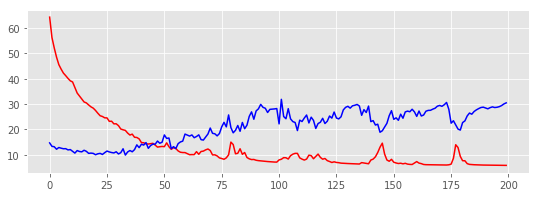

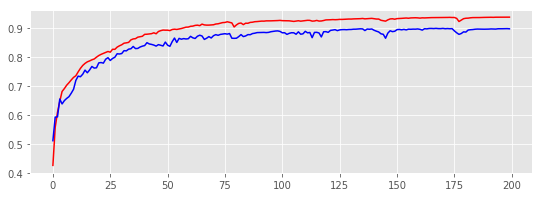

In [14]:
# cost_train
# cost_test
# acc_train
# acc_test
fig = plt.figure(figsize=(9,3))
plt.plot(cost_train, 'r-')
plt.plot(cost_test, 'b-')

# plt.axis([0,training_iterations,0,np.max(cost_history)])
plt.show()


fig = plt.figure(figsize=(9,3))
plt.plot(acc_train, 'r-')
plt.plot(acc_test, 'b-')
# plt.axis([0,training_iterations,0,np.max(cost_history)])
plt.show()

# Restore the best model

In [15]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

session =  tf.Session()

saver.restore(session, model_save_path)
print("Model restored.")

INFO:tensorflow:Restoring parameters from SaveModel/best_model.ckpt
Model restored.


# Evaluate model

In [16]:
pred_y_list = np.zeros(0)

acc_list = []
loss_list = []

#       Performance on testing dataset:
for i in range(n_batches_test):
    if i == n_batches_test-1:
        batch_x = X_test[i * batch_size:, :, :, :]
        batch_y = Y_test[i * batch_size:, :]
    else:
        offset = (i * batch_size) % (Y_test.shape[0] - batch_size)
        batch_x = X_test[offset:(offset + batch_size), :, :, :]
        batch_y = Y_test[offset:(offset + batch_size), :]

#     logits, y_pred = session.run([logits, prediction], feed_dict={X: batch_x, Y : batch_y})
    y_pred, acc, c = session.run([prediction, accuracy, loss_func], feed_dict={X: batch_x, Y : batch_y, keep_prob:1.,  annealing_step:100*n_batches})

    print('epoch %d - %d%% -%f) '% (i+1, (100*(i+1))//n_batches_test, acc), end='\r' if i<n_batches_test-1 else '')
#     y_pred = np.argmax(logits, axis=1)
#     pred_y_list.append(y_pred)
    pred_y_list = np.concatenate([pred_y_list, y_pred])
    
    acc_list.append(acc)
    loss_list.append(c)
#     test_acc = np.array(np.array(acc_list).mean())
#     test_loss = np.array(np.array(loss_list).sum())
    

test_acc = np.array(np.array(acc_list).mean())
test_loss = np.array(np.array(loss_list).sum())
print('Testing:\t  Loss: %2.4f \t Accuracy: %2.4f' % (test_loss/Y_test.shape[0], test_acc))

epoch 21 - 100% -0.918919) Testing:	  Loss: 0.0026 	 Accuracy: 0.8995


In [17]:
y_true = np.argmax(Y_test, 1)
y_pred =pred_y_list

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



print('Accuracy on testing data:',sum(y_pred==y_true)/y_true.shape[0])
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))

Accuracy on testing data: 0.8997147851688287
[[1233    1   22   24   33    2    3    7   17   23]
 [   1  304    6    1    1    2    0    3    0    6]
 [  10    0 1215   58    3    8    2    0   11  102]
 [  12    1   66 1004    9    5    3    8   12   21]
 [   6    4   20   16 1082    2    5   31    6   26]
 [  50    7   11   38    7 1147   28   54   11   21]
 [   0    0    4    8    3    2  133    0    0    1]
 [   5    1    3    6    3    2    1 1204    0   12]
 [   2    0   19    8    1    3    1    2 1245    6]
 [  20    5   79   28    7    5    0   12   15 1212]]
the mean-f1 score: 0.89


# Uncertainty output:

In [19]:
pred_y_list = np.zeros(0)
uncertainty_y_list = np.zeros([0,1])

acc_list = []
loss_list = []

#       Performance on testing dataset:
for i in range(n_batches_test):
    if i == n_batches_test-1:
        batch_x = X_test[i * batch_size:, :, :, :]
        batch_y = Y_test[i * batch_size:, :]
    else:
        offset = (i * batch_size) % (Y_test.shape[0] - batch_size)
        batch_x = X_test[offset:(offset + batch_size), :, :, :]
        batch_y = Y_test[offset:(offset + batch_size), :]

#     logits, y_pred = session.run([logits, prediction], feed_dict={X: batch_x, Y : batch_y})
    y_pred, acc, c, uncertainty = session.run([prediction, accuracy, loss_func, u], feed_dict={X: batch_x, Y : batch_y, keep_prob:1.,  annealing_step:100*n_batches})

    print('epoch %d - %d%% -%f) '% (i+1, (100*(i+1))//n_batches_test, acc), end='\r' if i<n_batches_test-1 else '')
#     y_pred = np.argmax(logits, axis=1)
#     pred_y_list.append(y_pred)
    pred_y_list = np.concatenate([pred_y_list, y_pred])
    uncertainty_y_list = np.concatenate([uncertainty_y_list, uncertainty])
    
    acc_list.append(acc)
    loss_list.append(c)
#     test_acc = np.array(np.array(acc_list).mean())
#     test_loss = np.array(np.array(loss_list).sum())
    

test_acc = np.array(np.array(acc_list).mean())
test_loss = np.array(np.array(loss_list).sum())
print('Testing:\t  Loss: %2.4f \t Accuracy: %2.4f' % (test_loss/Y_test.shape[0], test_acc))

epoch 21 - 100% -0.918919) Testing:	  Loss: 0.0026 	 Accuracy: 0.8995


In [22]:
print('True \t Predict  Uncertainty \t Match:')
for i in range(20):
# for i in range(pred_y_list.shape[0]):
    if np.argmax(Y_test[i]) != pred_y_list[i]:
        print(np.argmax(Y_test[i]), '\t', pred_y_list[i], '\t', uncertainty_y_list[i], '\t!!!')
    else:
        print(np.argmax(Y_test[i]), '\t', pred_y_list[i], '\t', uncertainty_y_list[i])

True 	 Predict  Uncertainty 	 Match:
3 	 3.0 	 [0.12549192]
3 	 3.0 	 [0.00045379]
5 	 9.0 	 [0.9929685] 	!!!
8 	 8.0 	 [0.00045379]
4 	 4.0 	 [0.00045379]
0 	 0.0 	 [0.00045379]
0 	 0.0 	 [0.00045379]
4 	 4.0 	 [0.00045379]
0 	 2.0 	 [0.99995458] 	!!!
3 	 3.0 	 [0.00041275]
4 	 4.0 	 [0.00045379]
4 	 4.0 	 [0.00045379]
1 	 1.0 	 [0.00045379]
9 	 2.0 	 [0.99986488] 	!!!
8 	 8.0 	 [0.00045379]
0 	 0.0 	 [0.00045379]
8 	 8.0 	 [0.00045379]
8 	 8.0 	 [0.00045379]
0 	 3.0 	 [0.99995458] 	!!!
7 	 7.0 	 [0.00045379]
